In [23]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Any, Dict
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

While doing this, the following was my initial model it is a simple KNN model that uses a set of simple features from the data set given.

In [16]:
df = pd.read_csv('../Data/books.csv')
df.columns = [col.replace(' ', '').strip() for col in df.columns]
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')
df['publication_year'] = df['publication_date'].dt.year
df.set_index('bookID', inplace=True, drop=True)
df.to_csv('../Data/books_cleaned.csv')
#df = df[df['ratings_count']>=20] Feel free to uncoment this to see what the effect is the eval time is rather long sadly.

In [12]:
def preprocess_data(df: pd.DataFrame, threshold: Union[float, int] =0.3) -> pd.DataFrame:
    """
    Performs combined preprocessing on the given DataFrame. It includes cleaning, 
    formatting, and preparing the data for the KNN model.

    Args:
    df (pd.DataFrame): The DataFrame to preprocess.
    threshold (float or int): The threshold for dropping columns with NaN values.

    Returns:
    tuple: A tuple containing the ColumnTransformer and the preprocessed DataFrame.

    Description:
    The function performs the following steps:
    1. Drops columns with more than a specified threshold of NaN values.
    2. Sets 'bookID' as the index of the DataFrame and drops the old index.
    3. Removes whitespace and strips spaces from column names.
    4. Replaces 'J.K. Rowling-Mary GrandPré' with 'J.K. Rowling'.
    5. Converts 'num_pages' and 'average_rating' to numeric, coercing errors.
    6. Drops rows where 'num_pages', 'average_rating', or 'publication_date' are NaN.
    7. Converts 'publication_date' to just the year.
    8. Selects relevant features and applies ColumnTransformer for model preparation.
    """

    nan_percentage = df.isna().mean()
    df = df.drop(columns=nan_percentage[nan_percentage > threshold].index)
    df.replace(to_replace='J.K. Rowling-Mary GrandPré', value='J.K. Rowling', inplace=True)
    for col in ['num_pages', 'average_rating']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['num_pages', 'average_rating', 'publication_date'])
    
    features = ['authors', 'average_rating', 'language_code', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_year']
    df = df[features]
    column_transformer = ColumnTransformer([
        ('numerical', StandardScaler(), ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_year']),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['authors', 'language_code']),
    ])

    return column_transformer, df

In [21]:
def find_optimal_k(processed_df, column_transformer, k_range):
    """
    Determine the optimal number of neighbors for kNN using the elbow method.

    Arguments:
    processed_df (DataFrame): Preprocessed DataFrame used for kNN.
    column_transformer (ColumnTransformer): Transformer for preprocessing steps.
    k_range (range): Range of k values to test.

    Returns:
    Elbow plot of average distances for different values of k.
    """
    average_distances = []

    for k in k_range:
        knn = Pipeline(steps=[('preprocessor', column_transformer),
                              ('classifier', NearestNeighbors(n_neighbors=k, metric='cosine'))])
        knn.fit(processed_df)

        distances, _ = knn.named_steps['classifier'].kneighbors(knn.named_steps['preprocessor'].transform(processed_df))
        average_distance = np.mean(distances[:, -1])
        average_distances.append(average_distance)

    plt.figure(figsize=(8, 4))
    plt.plot(k_range, average_distances, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Average Distance to k-th Nearest Neighbor')
    plt.title('Elbow Method For Optimal k in kNN')
    plt.grid(True)
    plt.show()



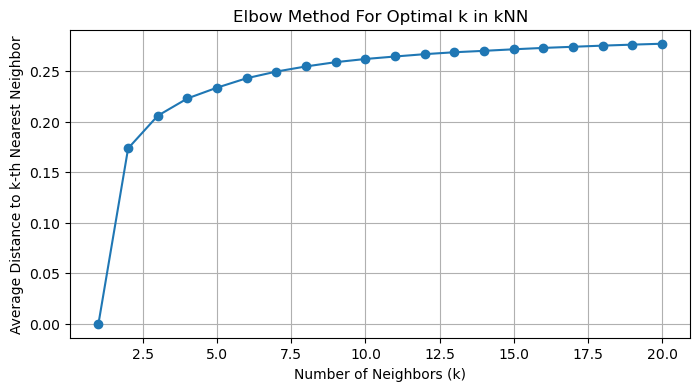

In [22]:
column_transformer, processed_df = preprocess_data(df)
k_range = range(1, 21) 
find_optimal_k(processed_df, column_transformer, k_range)

Looking at our elbow plot 5 seems like a reasonable k value.

In [13]:

column_transformer, processed_df = preprocess_data(df)

knn = Pipeline(steps=[('preprocessor', column_transformer),
                      ('classifier', NearestNeighbors(n_neighbors=5, metric='cosine'))])

knn.fit(processed_df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['average_rating',
                                                   'num_pages', 'ratings_count',
                                                   'text_reviews_count',
                                                   'publication_year']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['authors',
                                                   'language_code'])])),
                ('classifier', NearestNeighbors(metric='cosine'))])

In [15]:
with open('../Models/knn_model_initial.pkl', 'wb') as file:
    pickle.dump(knn, file)

In [9]:

def make_recommendation(model, df, book_title_or_isbn, top_n=5):
    """
    Makes book recommendations based on a given book title or ISBN.

    Args:
    model (Pipeline): The trained KNN pipeline model.
    df (pd.DataFrame): The DataFrame containing the book data.
    book_title_or_isbn (str): The book title or ISBN to base recommendations on.
    top_n (int): The number of recommendations to return.

    Returns:
    list: A list of recommended book titles.
    """
    book = df[(df['title'].str.contains(book_title_or_isbn, na=False, case=False)) |
              (df['isbn'] == book_title_or_isbn) | (df['isbn13'] == book_title_or_isbn)]
    if book.empty:
        return "Book not found."
    index = book.index[0]
    preprocessed_book_features = model.named_steps['preprocessor'].transform(df[df.index == index])
    distances, indices = model.named_steps['classifier'].kneighbors(preprocessed_book_features)
    recommendations = df.iloc[indices[0]].title.tolist()

    return recommendations




In [10]:
# Example Usage
book_title_or_isbn = 'The Lion  the Witch and the Wardrobe'
recommendations = make_recommendation(knn, df, book_title_or_isbn)
recommendations

['Essence and Alchemy: A Natural History of Perfume',
 'The Call of the Wild and Three Other Klondike Stories',
 "The Devil's Feather",
 'How to Read Literature Like a Professor',
 'Great Russian Short Stories']

In [24]:
def get_all_recommendations(model: Any, test_df: pd.DataFrame, full_df: pd.DataFrame, top_n: int = 5) -> List[str]:
    """
    Generate a list of all recommendations for each item in the test DataFrame.

    Arguments:
    model (Any): The recommendation model to be used.
    test_df (DataFrame): The test DataFrame containing the data for which recommendations are to be made.
    full_df (DataFrame): The full DataFrame containing all data available for making recommendations.
    top_n (int): The number of top recommendations to generate for each item (default is 5).

    Returns:
    List[str]: A list of all recommendations.
    """
    all_recommendations = []
    for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
        book_title_or_isbn = row['isbn']
        recommendations = make_recommendation(model, full_df, book_title_or_isbn, top_n)
        try:
            if isinstance(recommendations, list):
                all_recommendations.extend(recommendations)
        except Exception as e:
            print(e)
            print(book_title_or_isbn)
        
    return all_recommendations

In [25]:
def calculate_diversity(recommendations: List[str]) -> float:
    """
    Calculate the diversity of the given list of recommendations.

    Arguments:
    recommendations (List[str]): A list of recommended items.

    Returns:
    float: The diversity score of the recommendations.
    """
    unique_recommendations = len(set(recommendations))
    total_recommendations = len(recommendations)
    diversity = unique_recommendations * 100 / total_recommendations
    return diversity


In [26]:
def calculate_catalog_coverage(recommendations: List[str], catalog: List[str]) -> float:
    """
    Calculate the catalog coverage of the given recommendations.

    Arguments:
    recommendations (List[str]): A list of recommended items.
    catalog (List[str]): The complete list of items in the catalog.

    Returns:
    float: The catalog coverage percentage.
    """
    recommended_items = set(recommendations)
    catalog_items = set(catalog)
    coverage = len(recommended_items.intersection(catalog_items)) * 100 / len(catalog_items)
    return coverage


In [ ]:
recommendations = get_all_recommendations(knn, df)

Note that the above functions take a long time to run, something I never quite figured is a way to speed up bulk recommendations. Given more time it is something that I would improve.

In [56]:
unique_titles = df.drop_duplicates(subset='isbn')['title'].tolist()


In [63]:
print(f'Diversity score: {calculate_diversity(recommendations)} %')
print(f'Catalog coverage: {calculate_catalog_coverage(recommendations, unique_titles)} %')

Diversity score: 18.59620742338456 %
Catalog coverage: 99.94203458603033 %


Very low diversity, suggesting some books dominate the recomendatons. But as a result of running all the books through we have near 100% coverage, it is a slight worry that some books still aren't recommended.

In [54]:
sampled_df = df.sample(n=2000, random_state=42)
recommendations = get_all_recommendations(knn, sampled_df, df)

100%|██████████| 2000/2000 [00:42<00:00, 47.31it/s]


In [57]:
print(f'Diversity score: {calculate_diversity(recommendations)} %')
print(f'Catalog coverage: {calculate_catalog_coverage(recommendations, unique_titles)} %')

Diversity score: 52.43 %
Catalog coverage: 50.64245000483045 %


Considering the sample size compared to the catalog this is very impressive coverage, also the diversity is good. Seems like a decent model, lets trial an app design and do some emperical evidence gathering.

In [6]:
from flask import Flask, request, render_template_string
from threading import Thread

app = Flask(__name__)

html_template = '''
    <form method="post">
        <label for="book">Enter a Book Title or ISBN:</label>
        <input type="text" id="book" name="book">
        <input type="submit" value="Get Recommendations">
    </form>
    {% if recommendations %}
        <h3>Recommendations:</h3>
        <ul>
            {% for rec in recommendations %}
                <li>{{ rec }}</li>
            {% endfor %}
        </ul>
    {% endif %}
'''

@app.route('/', methods=['GET', 'POST'])
def index():
    recommendations = []
    if request.method == 'POST':
        book_title_or_isbn = request.form['book']
        recommendations = make_recommendation(knn, df, book_title_or_isbn, top_n=5)
    return render_template_string(html_template, recommendations=recommendations)

def run_app():
    
    app.run(port=5000, use_reloader=False)

thread = Thread(target=run_app)
thread.start()

 * Serving Flask app "__main__" (lazy loading)


 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [01/Dec/2023 13:55:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2023 13:55:18] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2023 13:55:33] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2023 13:55:40] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2023 13:55:48] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2023 13:56:01] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2023 13:56:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2023 13:56:31] "POST / HTTP/1.1" 200 -
